In [1]:
import nltk
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import featuretools as ft
import featuretools.variable_types as vtypes
import re
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

from featuretools.primitives.base.transform_primitive_base import (
    TransformPrimitive
)
from featuretools.primitives import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier


dtk = TreebankWordDetokenizer()
wn = nltk.WordNetLemmatizer()
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)

print('Featuretools version {}'.format(ft.__version__))


Featuretools version 0.9.0


In [2]:
def to_pd_arr(fp):
    tripreviews = open(fp).read()

    parsed_json = json.loads(tripreviews)
    holder_dict = {}
    counter = 0
    for rest in parsed_json['restaurants']:
        for review in rest['reviews']:
            holder_dict[counter] = {'title': review['review_title'], 'text': review['review_text'], 'date': review['review_date'], 'stars': review['review_rating'], 'price': rest['price']}
            counter += 1

    new_df = pd.DataFrame.from_dict(holder_dict, orient='index')

    return new_df

raw_data = to_pd_arr('rest-reviews.json')

raw_data['index'] = raw_data.index
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.head(6)

,title,text,date,stars,price,index
0,Great drinks and food,They have great local craft beers and probably...,2016-03-28,4,2,0
1,Good food &amp; beer,We went to the downtown SF location. The resta...,2016-03-27,4,2,1
2,Pretty good beers,I just came to this place for drinks with an o...,2016-03-16,4,2,2
3,Ridiculously overpriced (yes I live in SF),"Mediocre food (not bad, just mediocre, you can...",2016-03-08,3,2,3
4,Team dinner,We headed out for our team dinner to this esta...,2016-03-01,4,2,4
5,Brewery,Came here with my wife from Colorado for some ...,2016-02-23,4,2,5


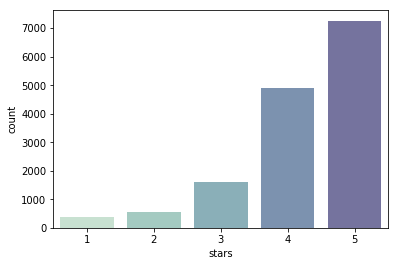

In [3]:
col = sns.color_palette("Blues")
sns.countplot(x=raw_data['stars'], palette = sns.cubehelix_palette(8, start=1, rot=-.75))

In [4]:
variable_types = {'index' : vtypes.Index,
                  'title': vtypes.Text,
                  'text': vtypes.Text,
                  'date': vtypes.Datetime,
                  'price': vtypes.Categorical}


In [5]:
rdc = raw_data.copy()
y = rdc.pop('stars')
X_train, X_test, y_train, y_test = train_test_split(rdc, y, test_size=0.15, stratify=y)


In [6]:
print(X_test.shape)

(2205, 5)


In [7]:
estrain = ft.EntitySet('Reviews')
estest = ft.EntitySet('Reviews')

estrain = estrain.entity_from_dataframe(entity_id="reviews",
                              dataframe=X_train,
                              index='index',
                              time_index="date",
                              variable_types=variable_types)

estest = estest.entity_from_dataframe(entity_id="reviews",
                              dataframe=X_test,
                              index='index',
                              time_index="date",
                              variable_types=variable_types)


In [8]:
pipeline = make_pipeline(TfidfVectorizer(), TruncatedSVD())

pipeline.fit(X_train['title'].append(X_train['text'], ignore_index=True))


Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('truncatedsvd',
                 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
                              random_state=None,

Now, to create some features for pre-processing:

In [9]:
class TitleCount(TransformPrimitive):
    """Computes the number of title words in a document/string"""
    
    name="title_word_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def title_count(array):
            return [len(re.findall(' [A-Z]|^[A-Z]', i)) for i in array]
        return title_count
    
class PunctuationCount(TransformPrimitive):
    """Computes the number of punctuation marks in a document/string"""
    
    name="punctuation_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def punctuation_count(array):
            punct = set(string.punctuation)
            toks = list(map(word_tokenize, array))
            return [sum(map(lambda x: x in punct, y)) for y in toks]
        return punctuation_count

class StopWordCount(TransformPrimitive):
    """Computes the number of stop words in a document/string"""
    
    name="stop_word_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def stop_words(array):
            swords = set(stopwords.words('english'))
            return [sum(map(lambda x: x in swords, word_tokenize(i))) for i in array]
        return stop_words
    
class CapitalCount(TransformPrimitive):
    """Computes the number of capital letters in a document/string"""
    
    name="capitals_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def capitals(array):
            return [len(re.findall('[A-Z]', i)) for i in array]
        return capitals

class WordCount(TransformPrimitive):
    """Computes the number of words in a document/string"""
    
    name="word_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def word_count(array):
            return [len(word_tokenize(x)) for x in array]
        return word_count

In [10]:
def clean_tokens(textstr):
    textstr = word_tokenize(textstr)
    processed = [ch.lower() for ch in textstr if ch not in
                                         set(string.punctuation).union(
                                         set(stopwords.words('english')))]
    processed = ['0' if re.search('[0-9]+', ch) else ch for ch in processed]
    processed = [wn.lemmatize(w) for w in processed]
    
    return processed

Now, for the more complicated, multi-output features:

In [11]:
class POS(TransformPrimitive):
    """Computes the number of each of the most common parts of speech used
       in a document/string"""
    
    name="POS_count"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    number_output_features=15
    
    def get_function(self):
        def pos(array):
            li = [nltk.pos_tag(clean_tokens(x)) for x in array]
            types = ['C', 'D', 'E', 'F', 'I', 'J',
                     'L', 'M', 'N', 'P', 'R', 'T',
                     'U', 'V', 'W']
            type_arr = []
            for row in li:
                fd = nltk.FreqDist([b[0] for (a,b) in row])
                type_arr.append([fd[i] for i in types])
            return np.array(type_arr).T
        return pos
    
class DiversityScore(TransformPrimitive):
    """Computes the diverity of words used in a document/string"""
    
    name="Diversity"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def diversity(array): 
            ret = []
            for x in array:
                y = clean_tokens(x)
                if len(y) < 1:
                    ret.append(0)
                else:
                    ret.append(len(set(y))/len(y))           
            return ret
        return diversity
    
class PolarityScore(TransformPrimitive):
    """Computes the percieved positivity(1) or negativity(-1) score of
       a document/string"""
    
    name="Polarity"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    
    def get_function(self):
        def polarity(array):
            vader = SentimentIntensityAnalyzer()
            def vader_pol(sentence):
                return (vader.polarity_scores(sentence)['pos'] - 
                       vader.polarity_scores(sentence)['neg'])
            return [vader_pol(dtk.detokenize(clean_tokens(x))) for x in array]
        return polarity

class LSA(TransformPrimitive):
    """Computes the latent semantic analysis of a document/string"""
    
    name="LSA"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    number_output_features=2
    
    def get_function(self):
        def lsa(array):
            array = array.apply(lambda x: dtk.detokenize(clean_tokens(x)))
            return np.array(pipeline.transform(array)).T
        return lsa

class USE(TransformPrimitive):
    """Computes the latent semantic analysis of a document/string"""
    
    name="USE"
    input_types=[vtypes.Text]
    return_type=vtypes.Numeric
    number_output_features=512
    
    def get_function(self):
        def use(array):
            array = array.apply(lambda x: dtk.detokenize(clean_tokens(x)))
            with tf.Session() as session:
                session.run([tf.global_variables_initializer(), tf.tables_initializer()])
                message_embeddings = session.run(embed(array.tolist()))
            return np.array(message_embeddings).T
        return use

In [12]:
trans = [TitleCount, 
         PunctuationCount,
         StopWordCount,
         CapitalCount,
         WordCount, 
         POS,
         DiversityScore,
         PolarityScore,
         LSA,
         USE]

train_feature_matrix, features = ft.dfs(entityset=estrain,
                              target_entity='reviews',
                              trans_primitives=trans,
                              verbose=True,
                              chunk_size=12495)

Built 21 features
Elapsed: 24:34 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [13]:
test_feature_matrix = ft.calculate_feature_matrix(features=features,
                                                  entityset=estest,
                                                  verbose=True,
                                                  chunk_size=2205)

Elapsed: 05:16 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [14]:
train_feature_matrix = train_feature_matrix.reindex(y_train.index)
test_feature_matrix = test_feature_matrix.reindex(y_test.index)

In [15]:
lgr = LogisticRegression(solver='lbfgs', multi_class='auto')
lgr.fit(train_feature_matrix, y_train)
lgr.score(test_feature_matrix, y_test)

/Users/featurelabs/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.5020408163265306

In [16]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(train_feature_matrix, y_train)
hgbc.score(test_feature_matrix, y_test)

0.6585034013605442

In [17]:
rfc = RandomForestClassifier(n_estimators=10, class_weight = "balanced", n_jobs=-1)
rfc.fit(train_feature_matrix, y_train)
rfc.score(test_feature_matrix, y_test)

0.5714285714285714

In [18]:
bnb = BernoulliNB()
bnb = bnb.fit(train_feature_matrix, y_train)
bnb.score(test_feature_matrix, y_test)

0.5133786848072562

In [19]:
vot = VotingClassifier(voting='soft', estimators=[('lgr', lgr), ('rfc', rfc), ('hgbc', hgbc)], weights=[1, 1, 5])
vot.fit(train_feature_matrix, y_train)
vot.score(test_feature_matrix, y_test)

/Users/featurelabs/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.6575963718820862

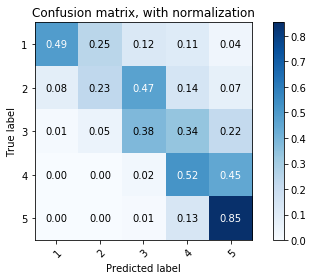

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(y_test, 
                      vot.predict(test_feature_matrix), 
                      ['1', '2', '3', '4', '5'], 
                      normalize=True, 
                      title='Confusion matrix, with normalization')

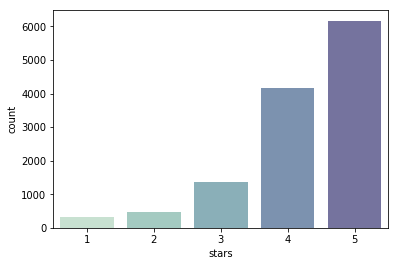

In [21]:
sns.countplot(x=y_train, palette = sns.cubehelix_palette(8, start=1, rot=-.75))


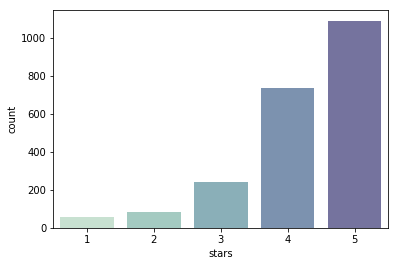

In [22]:
sns.countplot(x=y_test, palette = sns.cubehelix_palette(8, start=1, rot=-.75))


In [23]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(train_feature_matrix.columns, rfc.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                            score
USE(text)__149            0.0215013
POLARITY(title)           0.0113747
USE(text)__289            0.0101581
USE(title)__28            0.00905471
USE(text)__306            0.00834392
USE(text)__415            0.00815857
USE(text)__375            0.00769706
USE(text)__28             0.0060284
POLARITY(text)            0.00577826
USE(text)__237            0.00547146
USE(title)__415           0.00498163
USE(text)__486            0.00453621
USE(text)__333            0.00448002
USE(title)__333           0.00443498
USE(text)__259            0.00442267
USE(title)__259           0.00437924
USE(title)__348           0.00432312
USE(title)__297           0.00422213
USE(text)__362            0.00404388
USE(title)__149           0.00394888
USE(text)__452            0.00393827
USE(text)__90             0.00387372
USE(title)__63            0.00355848
USE(title)__328           0.00339486
USE(title)__133           0.00325809
USE(title)__446           0.00319721
USE(